In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numpy import sqrt
import jax
import jax.numpy as jnp
from scipy.special import logit, expit

In [2]:
At = lambda t, n: -n * jnp.log(1 - jax.scipy.special.expit(t))
g = lambda t, n, x: t * x - At(t, n)
dg = jax.grad(g)
dg_vmap = jax.vmap(dg, in_axes=(None, None, 0))

In [3]:
def simulate(n, p, nsims, thresh):
    delta = 0.01
    np.random.seed(0)
    samples = scipy.stats.binom.rvs(n, p, size=nsims)
    reject = samples >= thresh
    typeI_sum = np.sum(reject)
    typeI_score = np.sum(reject * (samples - n * p))
    return typeI_sum, typeI_score

In [4]:
def C_numerical(n_arm_samples, t, hp, hq):
    p = expit(t)
    xs = jnp.arange(n_arm_samples + 1).astype(jnp.float64)
    eggq = jnp.abs(dg_vmap(t, n_arm_samples, xs)) ** hq
    return sum(eggq * scipy.stats.binom.pmf(xs, n_arm_samples, p)) ** (1 / hq)

def holder_odi(typeI_sum, n_arm_samples, nsims, t_path, hp, delta=0.01):
    hq = 1 / (1 - 1 / hp)
    C = [C_numerical(n_arm_samples, t, hp, hq) for t in t_path]
    f0 = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum)
    return ((t_path - t_path[0]) * C / hq + f0 ** (1 / hq)) ** hq

In [5]:
def holder_odi_n(typeI_sum, n_arm_samples, nsims, t_path, hp, delta=0.01):
    hq = 1 / (1 - 1 / hp)
    f0 = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum)

    def derivs(t, y):
        cur_f = y[0]
        return C_numerical(n_arm_samples, t, hp, hq) * cur_f ** (1 / hp)
    
    t = t_path[0] 
    dt = t_path[-1] - t
    ode = scipy.integrate.solve_ivp(derivs, (t, t+dt), [f0], t_eval=t_path, rtol=1e-10, atol=1e-10)
    return ode['y'][0]

In [6]:
def taylor(typeI_sum, typeI_score, n_arm_samples, nsims, t_path, delta=0.01, delta_prop_0to1=0.5):
    f0 = scipy.stats.beta.ppf(1 - (delta * delta_prop_0to1), typeI_sum + 1, nsims - typeI_sum)

    grad_est = typeI_score / nsims
    covar = n_arm_samples * expit(t_path[0]) * (1 - expit(t_path[0]))
    grad_bound = np.sqrt(covar / nsims * (1 / ((1 - delta_prop_0to1) * delta) - 1))

    p = expit(t_path)
    hess_bound = n_arm_samples * p * (1 - p)

    t = t_path[0]
    return f0 + (grad_est + grad_bound) * (t_path - t) + 0.5 * hess_bound * (t_path - t) ** 2

In [54]:
def copt(a, p):
    return 1 / (1 + ((1-a)/a)**(1/(p-1)))

def centered_odi(typeI_sum, n_arm_samples, nsims, t_path, hp, delta=0.01, copt_f=copt, c_constant=False):
    hq = 1 / (1 - 1 / hp)
    f0 = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum)
    
    c = [copt_f(f0, hp) if c_constant else None]

    def derivs(t, y):
        cur_f = y[0]
        if not c_constant:
            c[0] = copt_f(cur_f, hp)
        cur_Fc = cur_f * (1 - c[0]) ** hp + (1 - cur_f) * c[0] ** hp
        return C_numerical(n_arm_samples, t, hp, hq) * cur_Fc ** (1 / hp)
    
    t = t_path[0] 
    dt = t_path[-1] - t
    centeredode = scipy.integrate.solve_ivp(derivs, (t, t+dt), [f0], t_eval=t_path, rtol=1e-10, atol=1e-10)
    return centeredode['y'][0]

def centered_analytical(typeI_sum, n_arm_samples, nsims, t_path, hp, delta=0.01):
    assert(isinstance(hp, int))
    assert(hp % 2 == 0)
    hq = 1 / (1 - 1 / hp)
    print(hp, hq)

    f0 = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum)
    centering = copt(f0, hp)
    ks = np.arange(hp + 1)
    A = (1 - centering) ** hp - centering ** hp
    B = centering ** hp

    C = np.array([C_numerical(n_arm_samples, t, hp, hq) for t in t_path])
    R = (A * f0 + B) ** (1 / hq)
    return ((((t_path - t_path[0]) * C * A / hq + R) ** hq) - B) / A

## Comparing bounds

In [57]:
def experiment(n, p, dt, nsims, thresh, hp, cp, cp_c=None, hp_n=None, include_taylor=True):
    t = logit(p)
    t_path = np.linspace(t, t + dt, 200)
    true_err = 1 - scipy.stats.binom.cdf(thresh - 1, n, expit(t_path))
    typeI_sum, typeI_score = simulate(n, p, nsims, thresh)

    if hp is not None:
        hob = holder_odi(typeI_sum, n, nsims, t_path, hp)
        plt.plot(t_path, hob, 'b-', label=f'holder({hp})')

    if hp_n is not None:
        hobn = holder_odi_n(typeI_sum, n, nsims, t_path, hp_n)
        plt.plot(t_path, hobn, 'b:', label=f'holder-numerical({hp_n})')

    if include_taylor:
        tb = taylor(typeI_sum, typeI_score, n, nsims, t_path)
        plt.plot(t_path, tb, 'r--', label='taylor')

    if cp is not None:
        cob = centered_odi(typeI_sum, n, nsims, t_path, cp)
        plt.plot(t_path, cob, 'k:', label=f'centered({cp})')

    if cp_c is not None:
        cobc = centered_analytical(typeI_sum, n, nsims, t_path, cp_c)
        # cobc = centered_odi(typeI_sum, n, nsims, t_path, cp_c, c_constant=True)
        plt.plot(t_path, cobc, 'm:', label=f'centered-const({cp_c})')
    print(cobc - cob)

    plt.plot(t_path, true_err, 'k-', label='true')
    plt.xlabel(r'$\theta$')
    plt.ylabel('type I error')
    plt.legend()

UnboundLocalError: local variable 'cobc' referenced before assignment

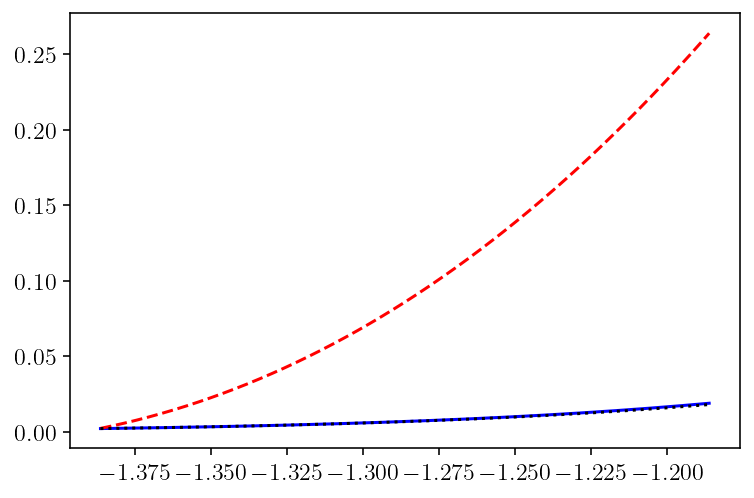

In [56]:
experiment(50, 0.2, 0.2, 10000, 20, 1.2, 1.2, cp_c=None)

2 2.0
[5.55111512e-17 1.22781607e-08 4.92356015e-08 1.11056854e-07 1.97926572e-07 3.10029536e-07
 4.47550647e-07 6.10674933e-07 7.99587543e-07 1.01447375e-06 1.25551896e-06 1.52290868e-06
 1.81682857e-06 2.13746439e-06 2.48500204e-06 2.85962750e-06 3.26152677e-06 3.69088610e-06
 4.14789190e-06 4.63273071e-06 5.14558919e-06 5.68665412e-06 6.25611240e-06 6.85415105e-06
 7.48095721e-06 8.13671815e-06 8.82162127e-06 9.53585406e-06 1.02796042e-05 1.10530593e-05
 1.18564074e-05 1.26898364e-05 1.35535345e-05 1.44476899e-05 1.53724909e-05 1.63281260e-05
 1.73147839e-05 1.83326532e-05 1.93819229e-05 2.04627818e-05 2.15754190e-05 2.27200239e-05
 2.38967856e-05 2.51058937e-05 2.63475377e-05 2.76219074e-05 2.89291925e-05 3.02695830e-05
 3.16432689e-05 3.30504405e-05 3.44912880e-05 3.59660019e-05 3.74747727e-05 3.90177910e-05
 4.05952477e-05 4.22073337e-05 4.38542400e-05 4.55361577e-05 4.72532782e-05 4.90057928e-05
 5.07938931e-05 5.26177706e-05 5.44776172e-05 5.63736247e-05 5.83059852e-05 6.027489

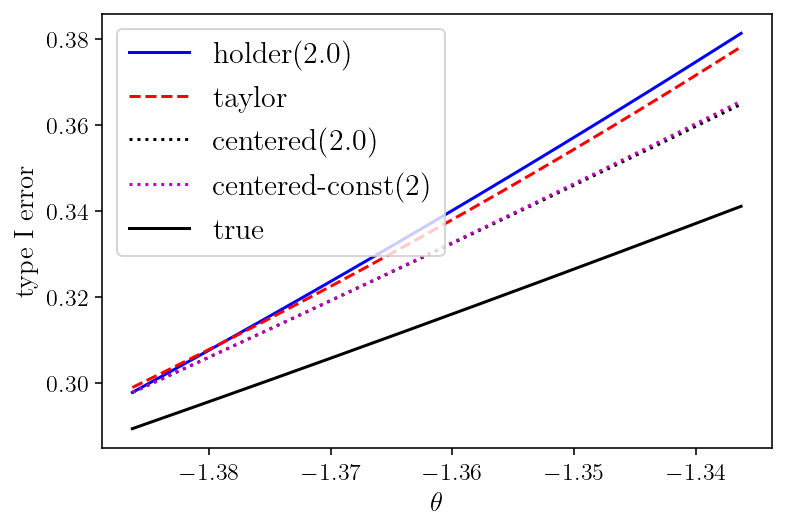

In [58]:
experiment(50, 0.2, 0.05, 10000, 12, 2.0, 2.0, cp_c=2)

2 2.0
[1.11022302e-16 2.74934897e-09 1.12097528e-08 2.56997188e-08 4.65377136e-08 7.40421645e-08
 1.08531459e-07 1.50323944e-07 1.99737929e-07 2.57091681e-07 3.22703429e-07 3.96891361e-07
 4.79973627e-07 5.72268335e-07 6.74093556e-07 7.85767318e-07 9.07607446e-07 1.03992970e-06
 1.18305159e-06 1.33729128e-06 1.50296692e-06 1.68039657e-06 1.86989825e-06 2.07178989e-06
 2.28638940e-06 2.51401460e-06 2.75498327e-06 3.00961313e-06 3.27822182e-06 3.56112695e-06
 3.85864605e-06 4.17109660e-06 4.49879602e-06 4.84206166e-06 5.20121083e-06 5.57656077e-06
 5.96842867e-06 6.37713163e-06 6.80298674e-06 7.24631099e-06 7.70742132e-06 8.18663464e-06
 8.68426775e-06 9.20063744e-06 9.73606042e-06 1.02908533e-05 1.08653327e-05 1.14598152e-05
 1.20746173e-05 1.27100552e-05 1.33664455e-05 1.40441043e-05 1.47433480e-05 1.54644927e-05
 1.62078546e-05 1.69737496e-05 1.77624938e-05 1.85744032e-05 1.94097936e-05 2.02689808e-05
 2.11522806e-05 2.20600088e-05 2.29924809e-05 2.39500126e-05 2.49329193e-05 2.594151

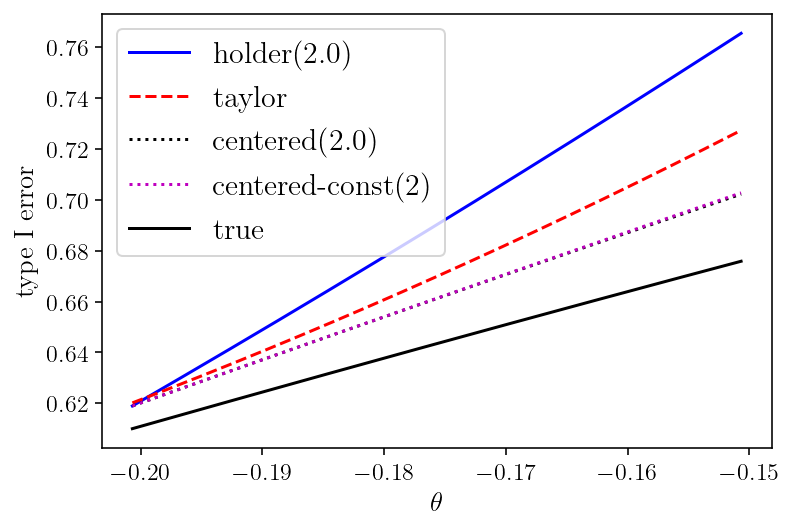

In [59]:
experiment(50, 0.45, 0.05, 10000, 22, 2.0, 2.0, cp_c=2)

8 1.1428571428571428
[-4.44089210e-16  2.24634811e-09  8.76339168e-09  1.92181464e-08  3.32776762e-08  5.06091130e-08
  7.08796802e-08  9.37567135e-08  1.18907684e-07  1.46000222e-07  1.74702135e-07  2.04681435e-07
  2.35606360e-07  2.67145394e-07  2.98967293e-07  3.30741106e-07  3.62136199e-07  3.92817799e-07
  4.22448585e-07  4.50700874e-07  4.77247401e-07  5.01761122e-07  5.23915235e-07  5.43383203e-07
  5.59838783e-07  5.72956046e-07  5.82409408e-07  5.87873652e-07  5.89023954e-07  5.85535911e-07
  5.77085567e-07  5.63349441e-07  5.44004554e-07  5.18728454e-07  4.87199251e-07  4.49095640e-07
  4.04096931e-07  3.51883084e-07  2.92134730e-07  2.24533212e-07  1.48760610e-07  6.44997743e-08
 -2.85656395e-08 -1.30751140e-07 -2.42371366e-07 -3.63740048e-07 -4.95169976e-07 -6.36972963e-07
 -7.89459808e-07 -9.52940255e-07 -1.12772296e-06 -1.31411544e-06 -1.51242405e-06 -1.72295392e-06
 -1.94600894e-06 -2.18189168e-06 -2.43090337e-06 -2.69334386e-06 -2.96951153e-06 -3.25970330e-06
 -3.56421

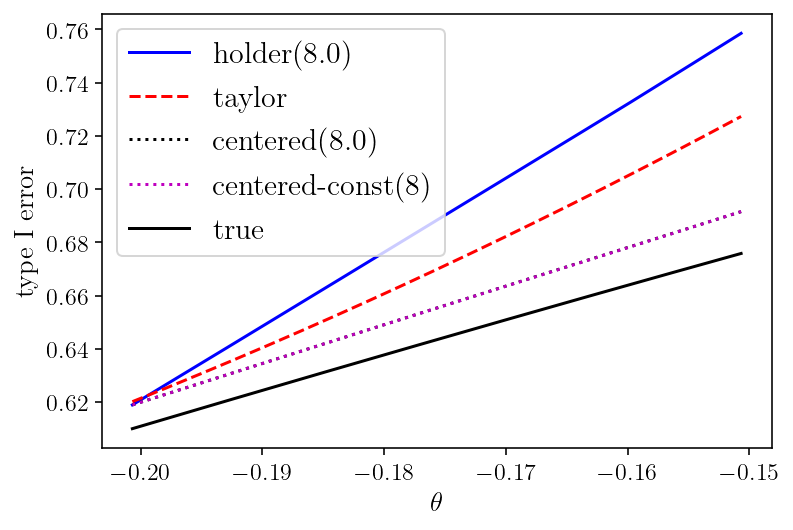

In [60]:
experiment(50, 0.45, 0.05, 10000, 22, 8.0, 8.0, cp_c=8)

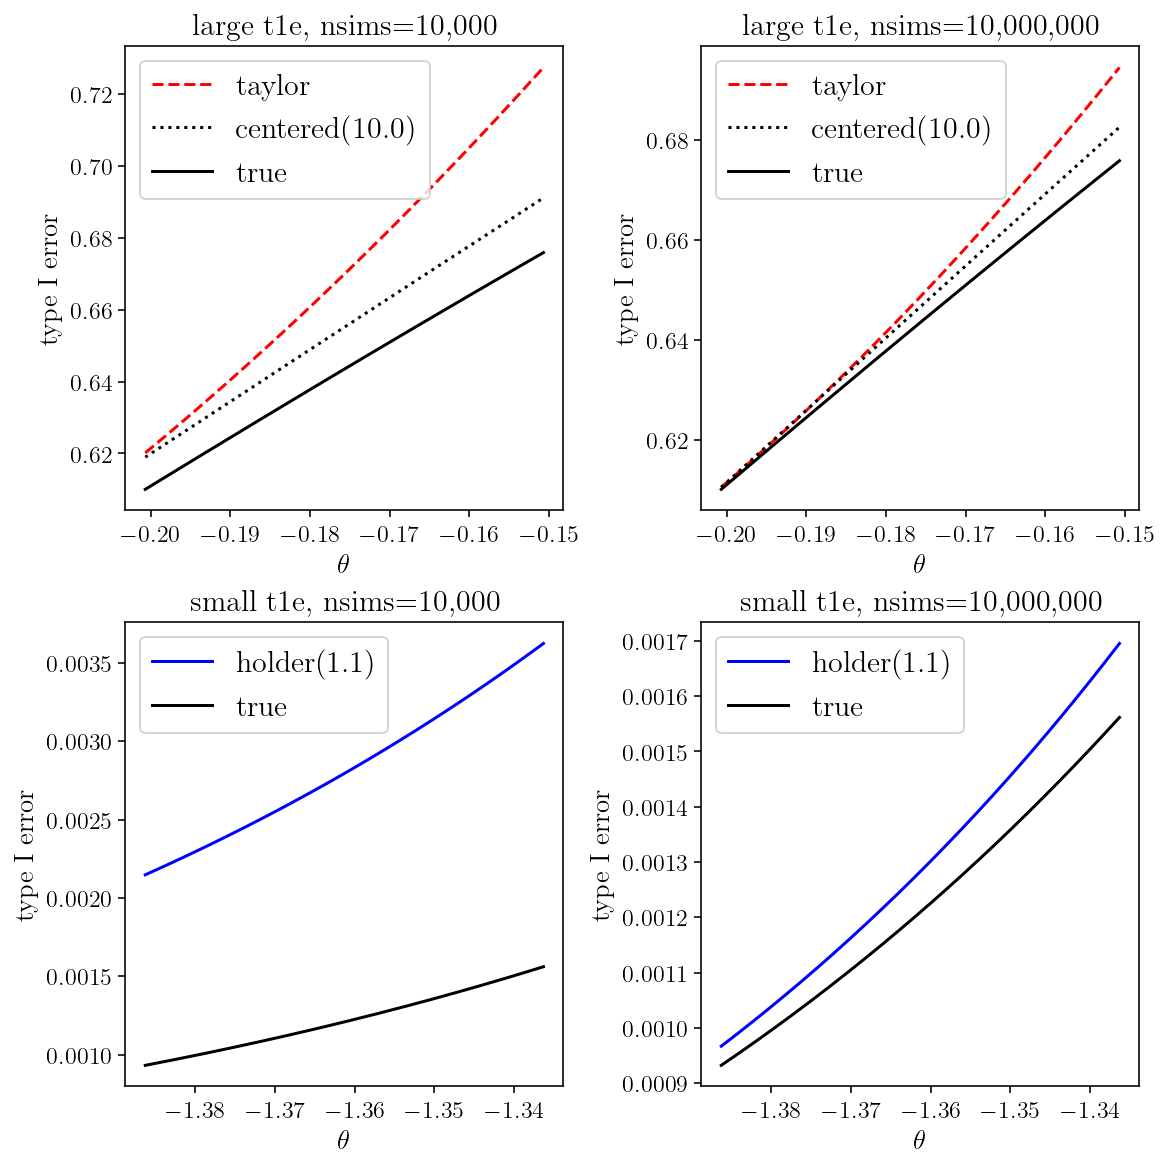

In [82]:
plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True)
plt.subplot(2,2,1)
plt.title('large t1e, nsims=10,000')
experiment(50, 0.45, 0.05, 10000, 22, None, 10.0)
plt.subplot(2,2,2)
plt.title('large t1e, nsims=10,000,000')
experiment(50, 0.45, 0.05, 10000000, 22, None, 10.0)
plt.subplot(2,2,3)
plt.title('small t1e, nsims=10,000')
experiment(50, 0.2, 0.05, 10000, 20, 1.1, None, include_taylor=False)
plt.subplot(2,2,4)
plt.title('small t1e, nsims=10,000,000')
experiment(50, 0.2, 0.05, 10000000, 20, 1.1, None, include_taylor=False)
plt.show()

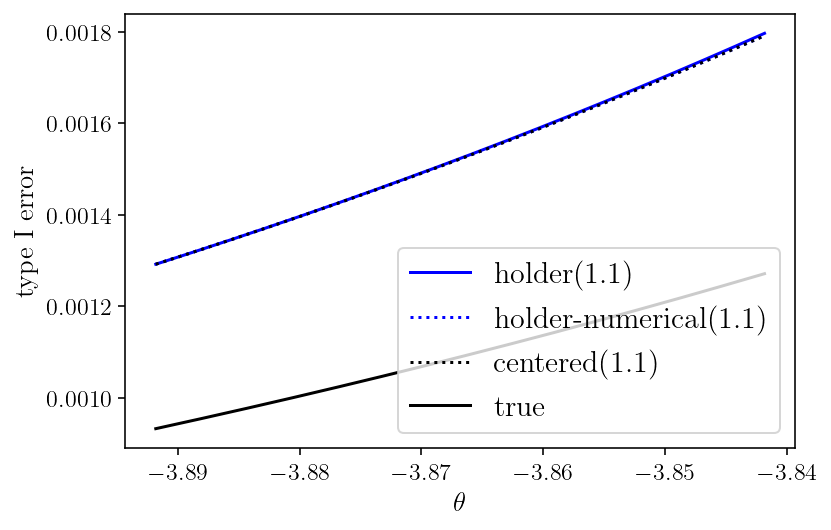

In [111]:
experiment(100, 0.02, 0.05, 100000, 8, 1.1, 1.1, 1.1, include_taylor=False)